In [1]:
from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
import define_rgbsample
import glob
import os
import re
import multiprocessing
import tqdm 
from galpy.util import bovy_coords
import safe_colours
safe_colours = safe_colours.initialise()
col_dict = safe_colours.distinct_named()
cm_rainbow = safe_colours.colourmap('rainbow')
cm_heat = safe_colours.colourmap('heat')
cm_diverging = safe_colours.colourmap('diverging') 
cols = safe_colours.distinct_list(3)



def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)


params = {'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'text.usetex': True, 'lines.linewidth': 1,
          'axes.titlesize': 14, 'font.family': 'serif'}
plt.rcParams.update(params)

columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/astjmack/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/home/astjmack/anaconda3/lib/python3.6/site-packages/astropy/coordinates/sky_coordinate.py:1598: AstropyDeprecationWarning: Passing a frame as a positional argument is now deprecated, use the frame= keyword argument instead.
  "instead.", AstropyDeprecationWarning)

/home/astjmack/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



In [2]:
orbitcat = fits.open('/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams.fits')[1].data

In [3]:
print('loading Gaia RV cat...')
files = glob.glob('/gal/GAIA/gdr2/gaia_source_with_rv/csv/*')

files = natural_sort(files)

def readfile(i):
    return ascii.read(files[i])

with multiprocessing.Pool(8) as p:
    chunks = list(tqdm.tqdm(p.imap(readfile, range(len(files))), total=len(files)))

source_ids = np.concatenate([np.array(chunks[i])['source_id'] for i in range(len(chunks))])

ra = np.concatenate([chunks[i]['ra'].filled(np.nan) for i in range(len(chunks))])
dec = np.concatenate([chunks[i]['dec'].filled(np.nan) for i in range(len(chunks))])
parallax = np.concatenate([chunks[i]['parallax'].filled(np.nan) for i in range(len(chunks))])
pmra = np.concatenate([chunks[i]['pmra'].filled(np.nan) for i in range(len(chunks))])
pmdec =  np.concatenate([chunks[i]['pmdec'].filled(np.nan) for i in range(len(chunks))])
rv = np.concatenate([chunks[i]['radial_velocity'].filled(np.nan) for i in range(len(chunks))])


ra_err = np.concatenate([chunks[i]['pmra_error'].filled(np.nan) for i in range(len(chunks))])
dec_err =  np.concatenate([chunks[i]['pmdec_error'].filled(np.nan) for i in range(len(chunks))])
parallax_err = np.concatenate([chunks[i]['parallax_error'].filled(np.nan) for i in range(len(chunks))])
pmra_err = np.concatenate([chunks[i]['pmra_error'].filled(np.nan) for i in range(len(chunks))])
pmdec_err =  np.concatenate([chunks[i]['pmdec_error'].filled(np.nan) for i in range(len(chunks))])
rv_err = np.concatenate([chunks[i]['radial_velocity_error'].filled(np.nan) for i in range(len(chunks))])
ra_dec_corr = np.concatenate([chunks[i]['ra_dec_corr'].filled(np.nan) for i in range(len(chunks))])
ra_parallax_corr= np.concatenate([chunks[i]['ra_parallax_corr'].filled(np.nan) for i in range(len(chunks))])
ra_pmra_corr = np.concatenate([chunks[i]['ra_pmra_corr'].filled(np.nan) for i in range(len(chunks))])
ra_pmdec_corr = np.concatenate([chunks[i]['ra_pmdec_corr'].filled(np.nan) for i in range(len(chunks))])
dec_parallax_corr= np.concatenate([chunks[i]['dec_parallax_corr'].filled(np.nan) for i in range(len(chunks))])
dec_pmra_corr = np.concatenate([chunks[i]['dec_pmra_corr'].filled(np.nan) for i in range(len(chunks))])
dec_pmdec_corr = np.concatenate([chunks[i]['dec_pmdec_corr'].filled(np.nan) for i in range(len(chunks))])
parallax_pmra_corr = np.concatenate([chunks[i]['parallax_pmra_corr'].filled(np.nan) for i in range(len(chunks))])
parallax_pmdec_corr =  np.concatenate([chunks[i]['parallax_pmdec_corr'].filled(np.nan) for i in range(len(chunks))])
pmra_pmdec_corr =  np.concatenate([chunks[i]['pmra_pmdec_corr'].filled(np.nan) for i in range(len(chunks))])

covariance = np.zeros([len(ra),6,6])
covariance[:,0,0] = ra_err**2
covariance[:,1,1] = dec_err**2
covariance[:,2,2] = parallax_err**2
covariance[:,3,3] = pmra_err**2
covariance[:,4,4] = pmdec_err**2
covariance[:,5,5] = rv_err**2
covariance[:,0,1] = ra_dec_corr*ra_err*dec_err
covariance[:,0,2] = ra_parallax_corr*ra_err*parallax_err
covariance[:,0,3] = ra_pmra_corr*ra_err*pmra_err
covariance[:,0,4] = ra_pmdec_corr*ra_err*pmdec_err
covariance[:,1,0] = covariance[:,0,1]
covariance[:,1,2] = dec_parallax_corr*dec_err*parallax_err
covariance[:,1,3] = dec_pmra_corr*dec_err*pmra_err
covariance[:,1,4] = dec_pmdec_corr*dec_err*pmdec_err
covariance[:,2,0] = covariance[:,0,2]
covariance[:,2,1] = covariance[:,1,2]
covariance[:,2,3] = parallax_pmra_corr*parallax_err*pmra_err
covariance[:,2,4] = parallax_pmdec_corr*parallax_err*pmdec_err
covariance[:,3,0] = covariance[:,0,3]
covariance[:,3,1] = covariance[:,1,3]
covariance[:,3,2] = covariance[:,2,3]
covariance[:,3,4] = pmra_pmdec_corr*pmra_err*pmdec_err
covariance[:,4,0] = covariance[:,0,4]
covariance[:,4,1] = covariance[:,1,4]
covariance[:,4,2] = covariance[:,2,4]
covariance[:,4,3] = covariance[:,3,4]

loading Gaia RV cat...


100%|██████████| 8/8 [03:39<00:00, 27.49s/it] 


In [4]:
sXYZ, svxyz, sRpz, svRvTvz = define_rgbsample.obs_to_galcen(ra, 
                                                                dec, 
                                                                1/parallax, 
                                                                pmra, 
                                                                pmdec, 
                                                                rv, 
                                                                pmra_err, 
                                                                pmdec_err, 
                                                                pmra_pmdec_corr, 
                                                                parallax_err, 
                                                                rv_err,
                                                                return_cov = False,
                                                                verbose = True,
                                                                return_rphiz = True,
                                                                ro = 8.,
                                                                vo = 220.,
                                                                zo = 0.025,
                                                                parallax=False)

In [14]:
parallax/parallax_err

array([44.68759594, 35.34654008, 96.76950942, ..., 32.90883418,
       42.64757003, 81.30141924])

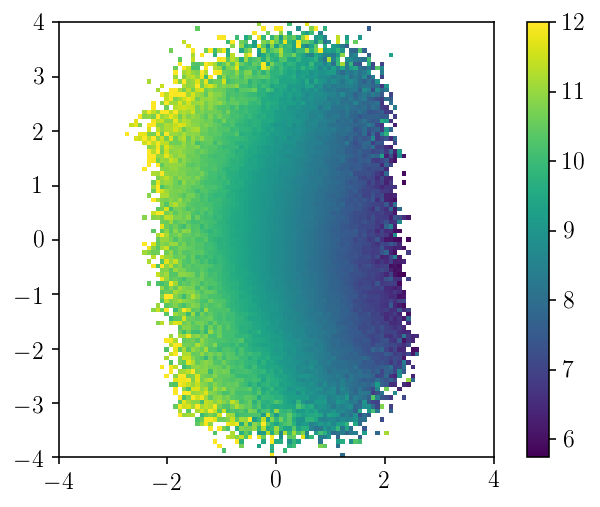

In [182]:
mask = (parallax/parallax_err > 20)  & (orbitcat['rap']/orbitcat['rap_err'] > 20) & (np.isfinite(orbitcat['rperi']))
tmin=-4
tmax=4
nbin=100
bins = np.linspace(tmin,tmax,nbin)
hist, xedges, yedges = np.histogram2d(sXYZ[:,0][mask]*8., sXYZ[:,1][mask]*8., bins=[bins,bins], weights=orbitcat['rap'][mask]*8.)
mhist, xedges, yedges = np.histogram2d(sXYZ[:,0][mask]*8., sXYZ[:,1][mask]*8., bins=[bins,bins])

plt.imshow(np.rot90(hist/mhist), extent = [tmin,tmax,tmin,tmax], vmax=12.)

plt.colorbar()


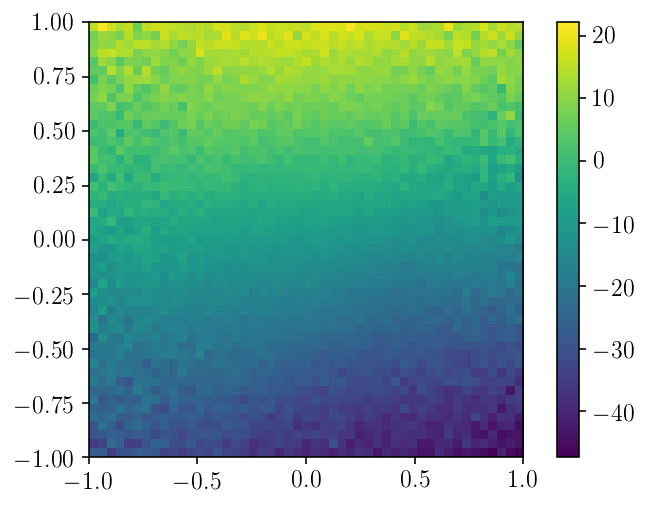

In [221]:
mask = (parallax/parallax_err > 20) 

numask = mask & (np.fabs(sRpz[:,2]*8.) < 1)
tmin=-1
tmax=1
nbin=50
bins = np.linspace(tmin,tmax,nbin)
hist, xedges, yedges = np.histogram2d(sXYZ[:,0][numask]*8., sXYZ[:,1][numask]*8., bins=[bins,bins], weights=svxyz[:,0][numask]*220.)
mhist, xedges, yedges = np.histogram2d(sXYZ[:,0][numask]*8., sXYZ[:,1][numask]*8., bins=[bins,bins])

plt.imshow(np.rot90(hist/mhist), extent = [tmin,tmax,tmin,tmax])

plt.colorbar()



In [209]:
rbins = np.linspace(0.,2.,40)
dist =  1/parallax[mask]
velocity = np.empty(len(rbins)-1)
vx = np.empty(len(rbins)-1)
vy = np.empty(len(rbins)-1)
vz = np.empty(len(rbins)-1)
for i in range(len(rbins)-1):
    rmask = (dist > rbins[i]) & (dist < rbins[i+1])
    velocity[i] = np.median(np.linalg.norm(svxyz[mask][rmask], axis=1))
    vx[i]= np.median(svxyz[mask][rmask][:,0])
    vy[i]= np.median(svxyz[mask][rmask][:,1])
    vz[i] = np.median(svxyz[mask][rmask][:,2])
bincent = (rbins[1:]+rbins[:-1])/2.

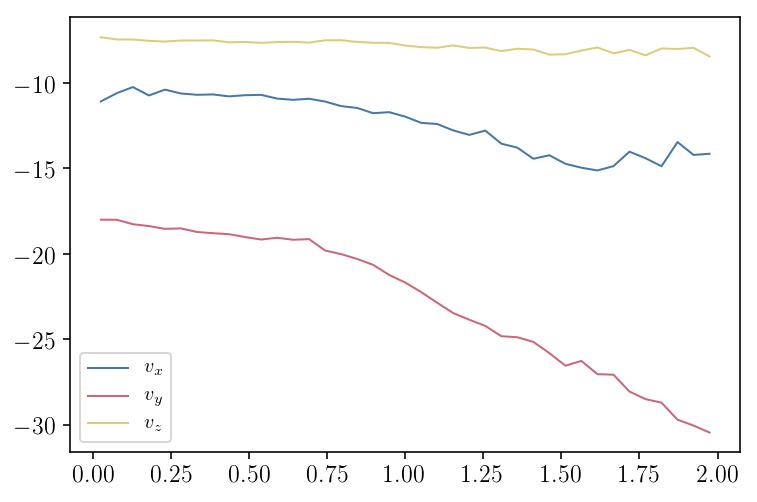

In [210]:
#plt.plot(bincent,velocity*220.)
plt.plot(bincent,vx*220., color=cols[0], label=r'$v_x$')
plt.plot(bincent,vy*220., color=cols[1], label=r'$v_y$')   
plt.plot(bincent,vz*220., color=cols[2], label=r'$v_z$')
plt.legend()

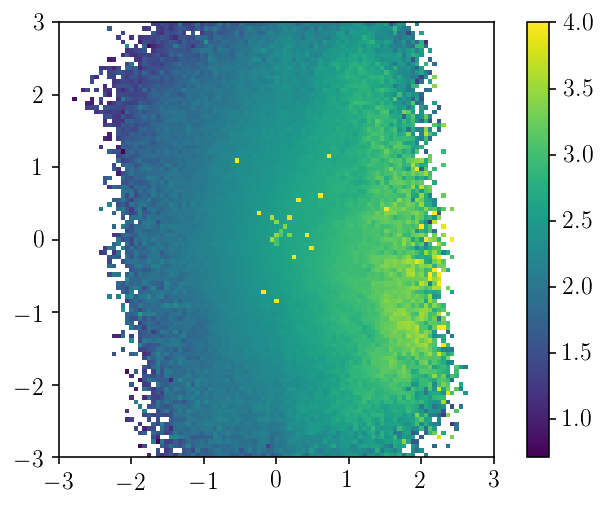

In [186]:
mask = (parallax/parallax_err > 20)  & (orbitcat['omega_z']/orbitcat['omega_z_err'] > 20) & (np.isfinite(orbitcat['omega_z']))
tmin=-3
tmax=3
nbin=100
bins = np.linspace(tmin,tmax,nbin)
hist, xedges, yedges = np.histogram2d(sXYZ[:,0][mask]*8., sXYZ[:,1][mask]*8., bins=[bins,bins], weights=orbitcat['omega_z'][mask])
mhist, xedges, yedges = np.histogram2d(sXYZ[:,0][mask]*8., sXYZ[:,1][mask]*8., bins=[bins,bins])

plt.imshow(np.rot90(hist/mhist), extent = [tmin,tmax,tmin,tmax], vmax=4.)

plt.colorbar()



8.45
9.05


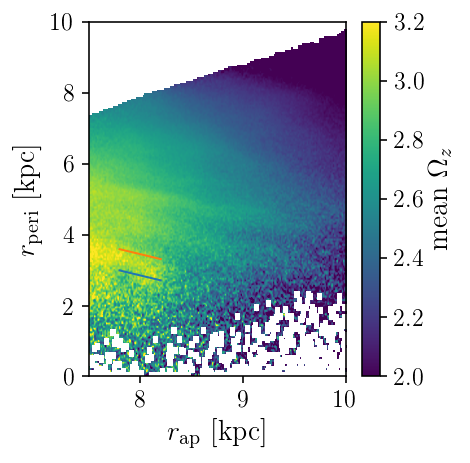

In [108]:
fig = plt.figure()
fig.set_size_inches(columnwidth,columnwidth)
xmin, xmax = 7.5, 10.
ymin, ymax = 0., 10.
xbins = np.linspace(xmin, xmax,200)
ybins = np.linspace(ymin ,ymax,200)
fin = np.isfinite(orbitcat['e']) & np.isfinite(orbitcat['omega_z'])
hist, yedges,xedges = np.histogram2d(orbitcat['rap'][fin]*8., orbitcat['rperi'][fin]*8., bins=[xbins,ybins])
mhist, yedges,xedges = np.histogram2d(orbitcat['rap'][fin]*8., orbitcat['rperi'][fin]*8., bins=[xbins,ybins], weights=orbitcat['omega_z'][fin])

plt.imshow(np.rot90(mhist/hist), extent = [xmin,xmax,ymin,ymax], aspect='auto', vmin=2., vmax=3.2, interpolation='gaussian')
plt.colorbar(label=r'$\mathrm{mean}\ \Omega_z$')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.xlabel(r'$r_\mathrm{ap}\ \mathrm{[kpc]}$')
plt.ylabel(r'$r_\mathrm{peri}\ \mathrm{[kpc]}$')
fig.tight_layout()

def line(x,m,edge,intercept_at_edge):
    c = intercept_at_edge-m*edge
    print(c)
    return m*x+c
newx = np.linspace(7.8,8.2,100)
plt.plot(newx,line(newx,-0.7,7.5,3.2))
plt.plot(newx,line(newx,-0.7,7.5,3.8))

plt.savefig('../plots/rperi_rap_omegaz.pdf', format='pdf')
plt.savefig('../plots/rperi_rap_omegaz.png', format='png', dpi=400)

10.55
10.95
10.45
11.05
/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10

10.55
10.95
/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10



Text(0.5,0,'$x\\ \\mathrm{[kpc]}$')

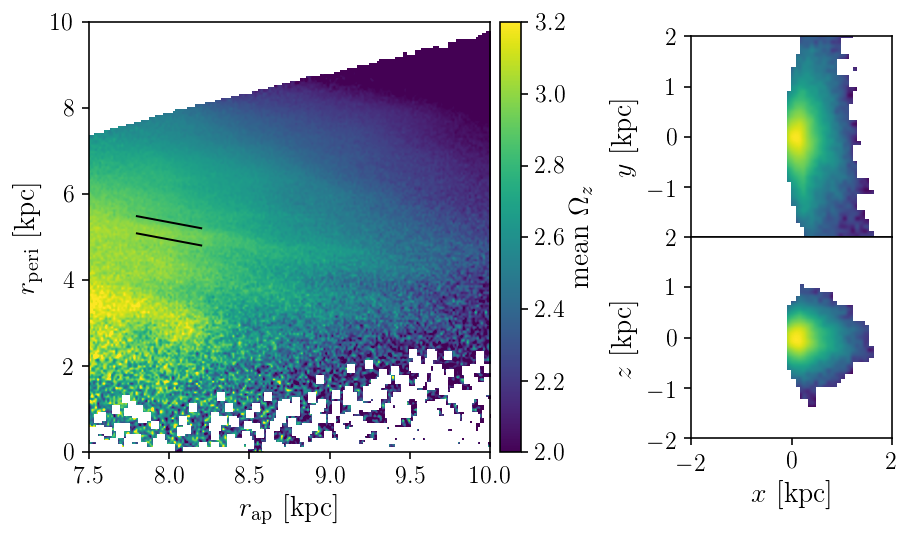

In [150]:
fig = plt.figure()
fig.set_size_inches(textwidth,columnwidth)
ax = fig.add_axes([0.1,0.1,0.4,0.9])
cax = fig.add_axes([0.51,0.1,0.02,0.9])
xmin, xmax = 7.5, 10.
ymin, ymax = 0., 10.
xbins = np.linspace(xmin, xmax,200)
ybins = np.linspace(ymin ,ymax,200)
fin = np.isfinite(orbitcat['e']) & np.isfinite(orbitcat['omega_z'])
hist, yedges,xedges = np.histogram2d(orbitcat['rap'][fin]*8., orbitcat['rperi'][fin]*8., bins=[xbins,ybins])
mhist, yedges,xedges = np.histogram2d(orbitcat['rap'][fin]*8., orbitcat['rperi'][fin]*8., bins=[xbins,ybins], weights=orbitcat['omega_z'][fin])
s = ax.imshow(np.rot90(mhist/hist), extent = [xmin,xmax,ymin,ymax], aspect='auto', interpolation='gaussian', vmin=2., vmax=3.2)
plt.colorbar(s,label=r'$\mathrm{mean}\ \Omega_z$', cax=cax)
ax.set_ylim(ymin,ymax)
ax.set_xlim(xmin,xmax)
ax.set_xlabel(r'$r_\mathrm{ap}\ \mathrm{[kpc]}$')
ax.set_ylabel(r'$r_\mathrm{peri}\ \mathrm{[kpc]}$')
def line(x,m,edge,intercept_at_edge):
    c = intercept_at_edge-m*edge
    print(c)
    return m*x+c
newx = np.linspace(7.8,8.2,100)
center = 5.5
ax.plot(newx,line(newx,-0.7,7.5,center-0.2), c='Black')
ax.plot(newx,line(newx,-0.7,7.5,center+0.2), c='Black')
ratio = textwidth/columnwidth

tmin=-2
tmax=2
nbin=50
bins = np.linspace(tmin,tmax,nbin)

xyax = fig.add_axes([0.7,0.55,0.2,0.2*ratio])

numask = mask & (orbitcat['rperi']*8. > line(orbitcat['rap']*8.,-0.7,7.5,center-0.3)) & (orbitcat['rperi']*8. < line(orbitcat['rap']*8.,-0.7,7.5,center+0.3)) & (orbitcat['rap']*8. < 8.2) & (orbitcat['rap']*8. > 7.8)
hist,xedges,yedges = np.histogram2d(sXYZ[:,0][numask]*8., sXYZ[:,1][numask]*8., bins=[bins,bins], normed=True)

xyax.imshow(np.log10(np.rot90(hist)), extent=[tmin,tmax,tmin,tmax], interpolation='gaussian')

xyax.set_ylabel(r'$y\ \mathrm{[kpc]}$')
xyax.set_xticks([])
xyax.set_yticks([-1,0.,1.,2.])

xzax = fig.add_axes([0.7,0.55-0.2*ratio,0.2,0.2*ratio])

numask = mask & (orbitcat['rperi']*8. > line(orbitcat['rap']*8.,-0.7,7.5,center-0.2)) & (orbitcat['rperi']*8. < line(orbitcat['rap']*8.,-0.7,7.5,center+0.2)) & (orbitcat['rap']*8. < 8.2) & (orbitcat['rap']*8. > 7.8)
hist,xedges,yedges = np.histogram2d(sXYZ[:,0][numask]*8., sXYZ[:,2][numask]*8., bins=[bins,bins], normed=True)

xzax.imshow(np.log10(np.rot90(hist)), extent=[tmin,tmax,tmin,tmax], interpolation='gaussian')

xzax.set_ylabel(r'$z\ \mathrm{[kpc]}$')
xzax.set_xlabel(r'$x\ \mathrm{[kpc]}$')

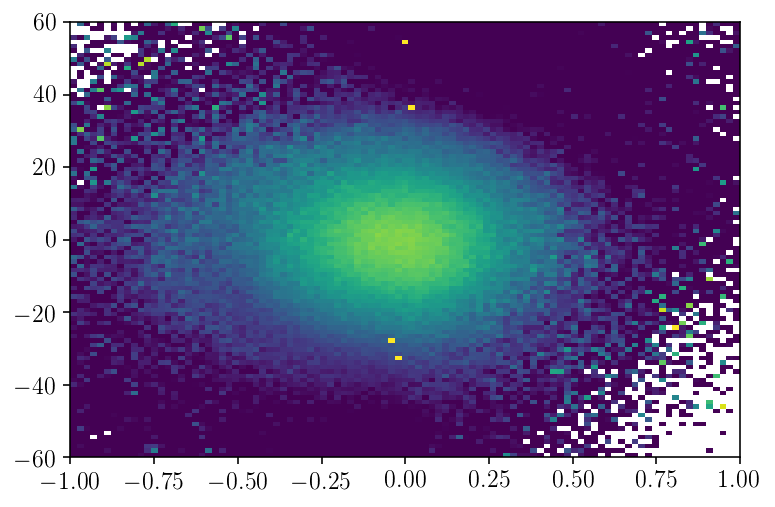

In [163]:
xbins = np.linspace(-1, 1,100)
ybins = np.linspace(-60,60,100)

y = svRvTvz[:,2][mask]*220.
x = sXYZ[:,2][mask]*8.

mhist, xedges, yedges = np.histogram2d(x,y,bins=[xbins,ybins])
hist, xedges, yedges = np.histogram2d(x,y,bins=[xbins,ybins], weights=orbitcat['omega_z'][mask])



plt.imshow(np.rot90(hist/mhist), vmin=2., vmax=3.2, extent=[-1,1,-60,60], aspect='auto')

/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()



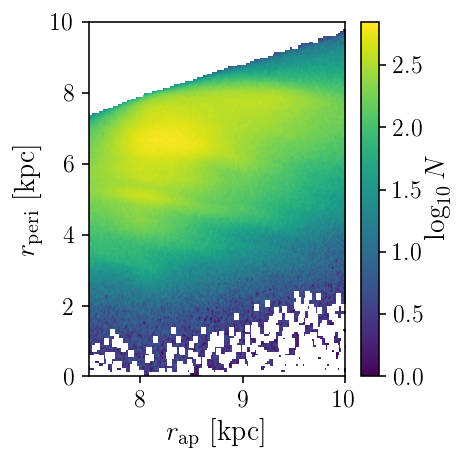

In [141]:
fig = plt.figure()
fig.set_size_inches(columnwidth,columnwidth)
xmin, xmax = 7.5, 10.
ymin, ymax = 0., 10.
xbins = np.linspace(xmin, xmax,200)
ybins = np.linspace(ymin ,ymax,200)
fin = np.isfinite(orbitcat['e']) & np.isfinite(orbitcat['omega_z'])
hist, yedges,xedges = np.histogram2d(orbitcat['rap'][fin]*8., orbitcat['rperi'][fin]*8., bins=[xbins,ybins])
mhist, yedges,xedges = np.histogram2d(orbitcat['rap'][fin]*8., orbitcat['rperi'][fin]*8., bins=[xbins,ybins], weights=orbitcat['omega_z'][fin])

plt.imshow(np.rot90(np.log10(hist)), extent = [xmin,xmax,ymin,ymax], aspect='auto', interpolation='gaussian')
plt.colorbar(label=r'$\log_{10}{N}$')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.xlabel(r'$r_\mathrm{ap}\ \mathrm{[kpc]}$')
plt.ylabel(r'$r_\mathrm{peri}\ \mathrm{[kpc]}$')
fig.tight_layout()
plt.savefig('../plots/rperi_rap_dens.pdf', format='pdf')
plt.savefig('../plots/rperi_rap_dens.png', format='png', dpi=400)

/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


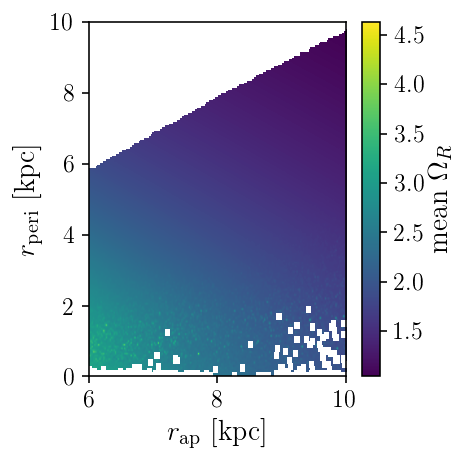

In [138]:
fig = plt.figure()
fig.set_size_inches(columnwidth,columnwidth)
xmin, xmax = 6, 10.
ymin, ymax = 0., 10.
xbins = np.linspace(xmin, xmax,200)
ybins = np.linspace(ymin ,ymax,200)
fin = np.isfinite(cat['e']) & np.isfinite(cat['omega_z'])
hist, yedges,xedges = np.histogram2d(cat['rap'][fin]*8., cat['rperi'][fin]*8., bins=[xbins,ybins])
mhist, yedges,xedges = np.histogram2d(cat['rap'][fin]*8., cat['rperi'][fin]*8., bins=[xbins,ybins], weights=cat['omega_r'][fin])

plt.imshow(np.rot90(mhist/hist), extent = [xmin,xmax,ymin,ymax], aspect='auto', interpolation='gaussian')
plt.colorbar(label=r'$\mathrm{mean}\ \Omega_R$')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.xlabel(r'$r_\mathrm{ap}\ \mathrm{[kpc]}$')
plt.ylabel(r'$r_\mathrm{peri}\ \mathrm{[kpc]}$')
fig.tight_layout()

In [132]:
np.sum(np.isfinite(cat['e']))

6643147

# Old Stuff

In [92]:
glob.glob('/gal/GAIA/gdr2/gaia_source_with_rv/csv/*')

['/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_6714230465835878784_6917528443525529728.csv.gz',
 '/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_5933051914143228928_6714230117939284352.csv.gz',
 '/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_1584380076484244352_2200921635402776448.csv.gz',
 '/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_4475722064104327936_5502601461277677696.csv.gz',
 '/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_5502601873595430784_5933051501826387072.csv.gz',
 '/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_2200921875920933120_3650804325670415744.csv.gz',
 '/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_2851858288640_1584379458008952960.csv.gz',
 '/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_3650805523966057472_4475721411269270528.csv.gz']

In [116]:
files = glob.glob('/gal/GAIA/gdr2/gaia_orbits/*')
print(list(files))
print(natural_sort(files))
sort = [6,2,5,7,3,4,1,0]
files = np.array(natural_sort(files))[sort]
print(files)

['/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_005.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_001.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_004.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_000.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_006.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_002.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_007.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_003.fits']
['/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_000.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_001.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_002.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_003.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_004.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_005.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_006.fits', '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_007.fits']
['/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams_006.f

In [113]:
test = ascii.read('/gal/GAIA/gdr2/gaia_source_with_rv/csv/GaiaSource_1584380076484244352_2200921635402776448.csv.gz')
test['source_id'][0]

1584380076484244352

In [112]:
cat['source_id'][0]

2073949100612172544

In [117]:
chunks  = []

for f in files:
    print(fits.open(f)[1].data['source_id'][0])
    chunks.append(fits.open(f)[1].data)

993680751682640896
2073949100612172544
3348172477502216704
4291236932247952000
5351814367925593216
5881862333541286400
6407520803912021760
6714230465835878784


In [118]:
cat = np.concatenate([chunks[i] for i in range(len(files))])

In [ ]:
sortcat= cat[np.argsort(cat['source_id'])]

In [125]:
sortcat['source_id'][3000000]

3650805523966057472

In [19]:
np.sum(np.isfinite(cat['e']))

6643147

In [128]:
newhdu = fits.BinTableHDU.from_columns(sortcat)
newhdu.writeto('/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams.fits')

In [129]:
test = fits.open('/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams.fits')

In [130]:
len(test[1].data)

7224631

In [20]:
ascii.write(cat, '/gal/GAIA/gdr2/gaia_orbits/gaiarvs_orbitparams.csv')

(array([9.660000e+02, 1.452000e+03, 2.277000e+03, 5.846000e+03,
        3.694000e+04, 6.828680e+05, 5.723784e+06, 3.515970e+05,
        3.918500e+04, 1.765500e+04]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <a list of 10 Patch objects>)

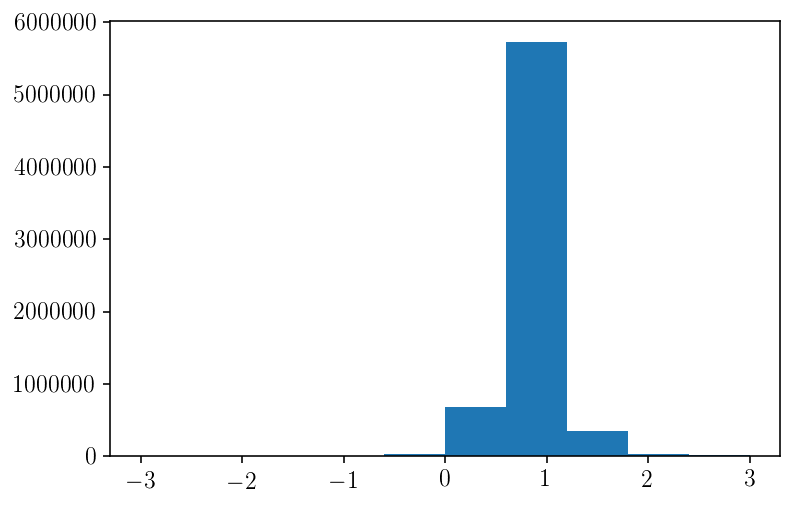

In [19]:
plt.hist(orbitcat['Lz'][np.isfinite(orbitcat['Lz'])], range=[-3,3])

In [57]:
mask = parallax/parallax_err > 20
omega_p = 1.85
m = 0.5

thing = 1./((orbitcat['omega_phi']-omega_p)-m*orbitcat['omega_R'])



(array([2.700000e+01, 7.700000e+01, 5.920000e+02, 1.161400e+04,
        1.250410e+05, 1.727061e+06, 3.836389e+06, 8.087190e+05,
        1.231560e+05, 5.453500e+05]),
 array([-9.43913545e-01, -8.49532190e-01, -7.55150834e-01, -6.60769479e-01,
        -5.66388123e-01, -4.72006768e-01, -3.77625412e-01, -2.83244057e-01,
        -1.88862701e-01, -9.44813456e-02, -9.99901010e-05]),
 <a list of 10 Patch objects>)

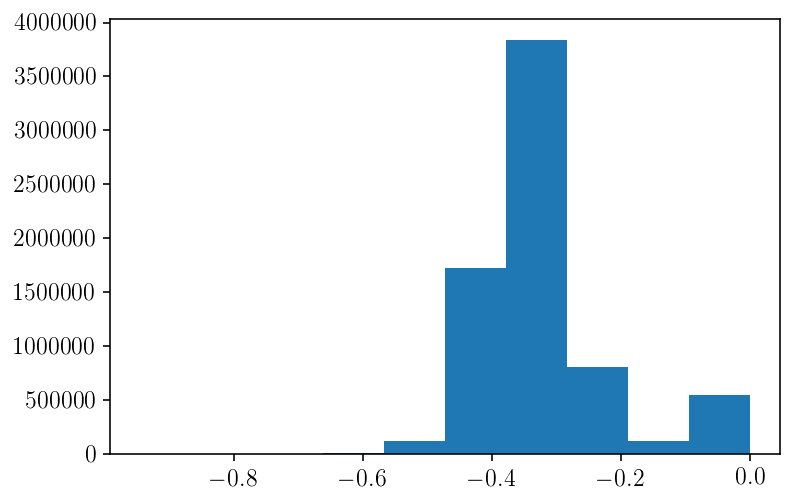

In [12]:
plt.hist(thing[np.isfinite(thing)],)

In [67]:
import numpy
sqrtjr = np.sqrt(orbitcat['jr'][mask])

Lz0_arr  = numpy.array([1.085,1.05,1.1,\
                1.03,\
                0.99,0.97,\
                0.946,0.95,0.925,\
                0.88,0.895,\
                0.835,0.83])
JR0_arr  = numpy.array([3.6,4.7,6.3,\
                        1.3,\
                        2.5,4.0,\
                        2.2,6.3,5.2,\
                        4.8,7.1,\
                        6.2,8.6])
Lzr_arr  = numpy.array([0.015,0.02,0.019,\
                        0.015,\
                        0.019,0.019,\
                        0.015,0.015,0.015,\
                        0.015,0.015,\
                        0.02,0.015])
JRr_arr  = numpy.array([1.2,0.9,1.,\
                        0.8,\
                        0.57,0.8,\
                        1.1,1.2,0.57,\
                        0.8,1.4,\
                        0.8,1.5])
angJ_arr = numpy.array([-0.02,0.005,0.01,\
                        -0.02,\
                        -0.01,0.01,\
                        0.023,0.01,0.02,\
                        0.01,-0.007,\
                        0.017,0.])
colorsJ_arr = ['gold','orange','yellow',\
               'crimson',\
               'deeppink','fuchsia',\
               'purple','hotpink','mediumpurple',\
               'cornflowerblue','mediumblue',\
               'limegreen','forestgreen']
 
def overplot_ellipse(ax,U0,V0,Ur,Vr,ang=0.,color='k',label=None):
    Ut = numpy.linspace(-Ur,Ur,100)
    Vt = Vr/Ur * numpy.sqrt(Ur**2-Ut**2)
    Ut = numpy.append(Ut,numpy.flip(Ut,0))
    Vt = numpy.append(Vt,-numpy.flip(Vt,0))
    temp = numpy.matmul(numpy.array([[numpy.cos(ang),-numpy.sin(ang)],[numpy.sin(ang),numpy.cos(ang)]]),numpy.array([Ut,Vt]))
    Up = temp[0]
    Vp = temp[1]
    ax.plot(Up+U0,Vp+V0,color=color,label=label,linewidth=2)
   

def index_ellipse(U_stars,V_stars,U0,V0,Ur,Vr,ang=0.):
    temp = numpy.matmul(numpy.array([[numpy.cos(-ang),-numpy.sin(-ang)],[numpy.sin(-ang),numpy.cos(-ang)]]),numpy.array([U_stars-U0,V_stars-V0]))
    Up = temp[0]
    Vp = temp[1]
    return (Up**2/Ur**2 + Vp**2/Vr**2) < 1

/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':



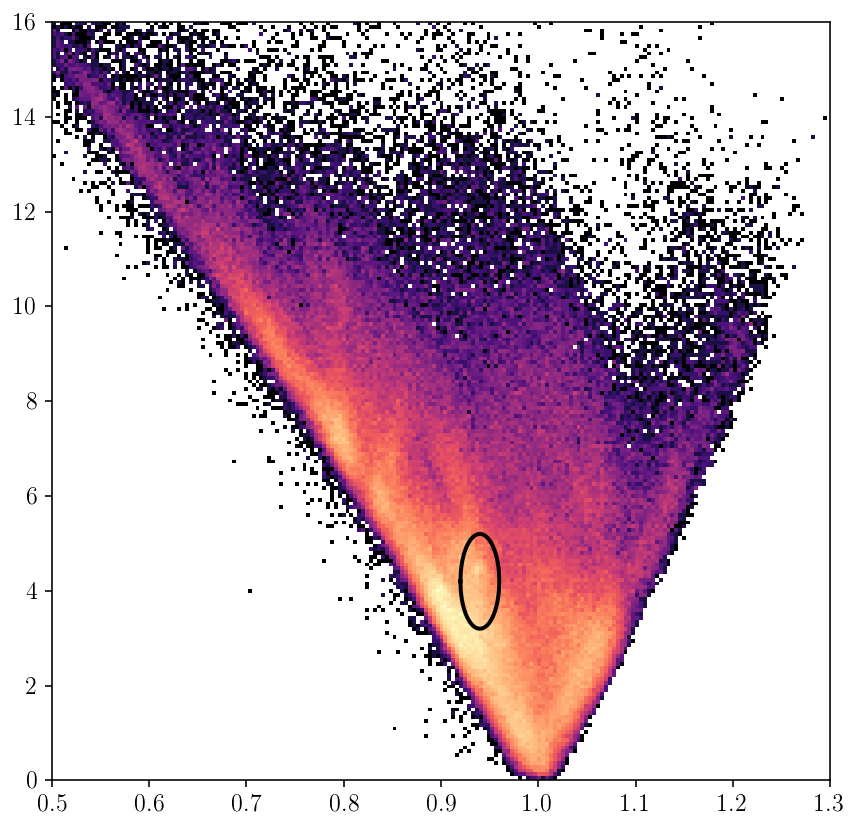

In [155]:
from scipy.stats import binned_statistic_2d
lzbins = np.linspace(0.5,1.3, 200)
jrbins = np.linspace(0.,16.,200)


fig = plt.figure()
fig.set_size_inches(textwidth,textwidth)

mask = np.isfinite(orbitcat['Lz']) & (parallax/parallax_err > 20) & (1/parallax < 0.2) 

hist, yedges, xedges = np.histogram2d(orbitcat['Lz'][mask], np.sqrt(orbitcat['jr'][mask]*8.*220.), bins=[lzbins,jrbins])
plt.imshow(np.rot90(np.log10(hist)), extent=[0.5,1.3,0.,16.], aspect='auto', cmap=plt.cm.magma)

#pos = [0.79,9.,0.02,2.,0.]
#pos = [0.84,6.8,0.02,2.,0.]
pos = [0.94,4.2,0.02,1.,0.]
overplot_ellipse(plt.gca(), pos[0], pos[1], pos[2], pos[3], ang=pos[4], color='Black', label=None)


In [156]:
inds = index_ellipse(orbitcat['Lz'][mask], np.sqrt(orbitcat['jr'][mask]*8.*220.), pos[0],pos[1],pos[2],pos[3],ang=pos[4])


1.4293302672428128 0.021013438834378645
1.0586618282781972 0.014753906198777094
1.7737737737737733


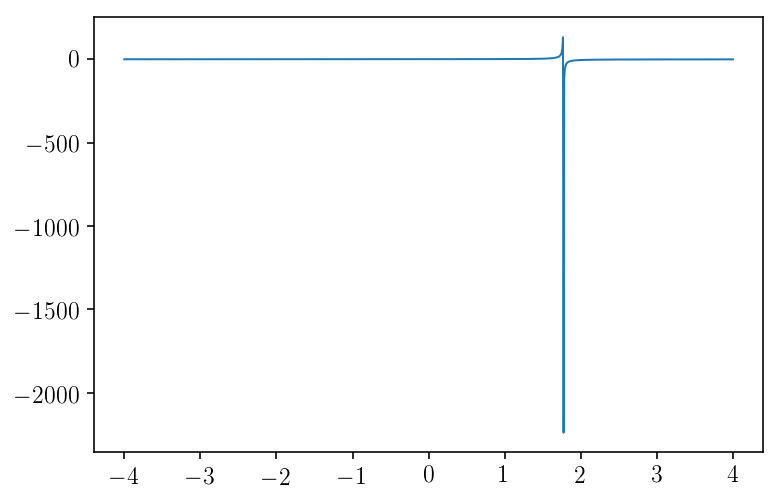

In [164]:
mean_omega_r = np.nanmean(orbitcat['omega_R'][mask][inds])
mean_omega_phi = np.nanmean(orbitcat['omega_phi'][mask][inds])
print(mean_omega_r, np.nanstd(orbitcat['omega_R'][mask][inds]))
print(mean_omega_phi, np.nanstd(orbitcat['omega_phi'][mask][inds]))


omega_p = np.linspace(-4.,4.,1000)
thing = 1/((mean_omega_phi-omega_p)+0.5*mean_omega_r)
plt.plot(omega_p, thing)
print(omega_p[np.argmin(thing)])

/home/astjmack/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':



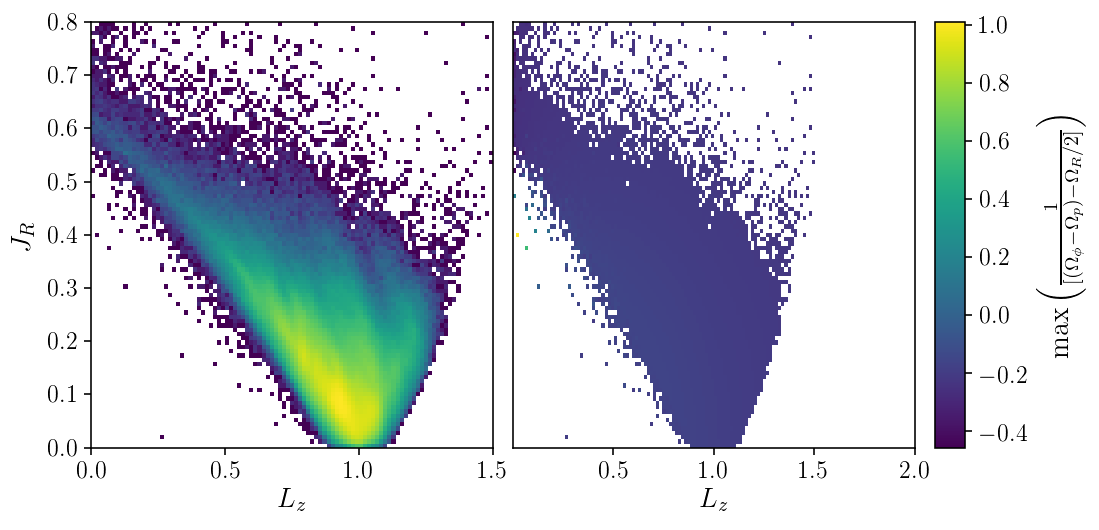

In [65]:
from scipy.stats import binned_statistic_2d
lzbins = np.linspace(0.,1.5, 100)
jrbins = np.linspace(0.,0.8,100)


fig = plt.figure()
fig.set_size_inches(textwidth,columnwidth)
ax = fig.add_axes([0.1,0.1,0.4,0.89])
mask = np.isfinite(orbitcat['Lz']) & (parallax/parallax_err > 20) & (1/parallax < 1.) & np.isfinite(thing)

hist, yedges, xedges = np.histogram2d(orbitcat['Lz'][mask], np.sqrt(orbitcat['jr'][mask]*8.*220.), bins=[lzbins,jrbins])
ax.imshow(np.rot90(np.log10(hist)), extent=[0.,1.5,0.,0.8], aspect='auto')

ax1 = fig.add_axes([0.52,0.1,0.4,0.89])

maxes = binned_statistic_2d(orbitcat['Lz'][mask], np.sqrt(orbitcat['jr'][mask]*8.*220.),np.abs(thing)[mask], 'max', bins=[lzbins,jrbins])
s = ax1.imshow(np.rot90(np.log10(maxes[0])), extent=[0.,1.5,0.,0.8], aspect='auto')
ax1.set_yticks([])
cax = fig.add_axes([0.94,0.1,0.03,0.89])
plt.colorbar(s, cax=cax, label=r'$\mathrm{max}\left(\frac{1}{[(\Omega_{\phi}-\Omega_p)-\Omega_R/2]}\right)$')
ax.set_ylabel(r'$\sqrt{J_R}$')
ax.set_xlabel(r'$L_z$')
ax1.set_xlabel(r'$L_z$')
ax1.set_xticks([0.5,1.,1.5,2.])

Text(0.5,0,'$L_z$')

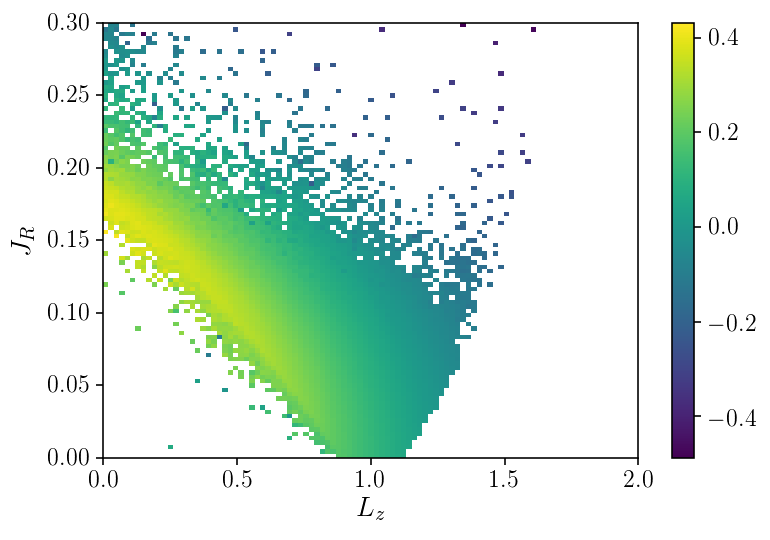

In [61]:

maxes = binned_statistic_2d(orbitcat['Lz'][mask], np.sqrt(orbitcat['jr'][mask]),orbitcat['omega_R'][mask], 'mean', bins=[lzbins,jrbins])
plt.imshow(np.rot90(np.log10(maxes[0])), extent=[0.,2.,0.,0.3], aspect='auto')

plt.colorbar()
plt.ylabel(r'$J_R$')
plt.xlabel(r'$L_z$')


Text(0.5,0,'$L_z$')

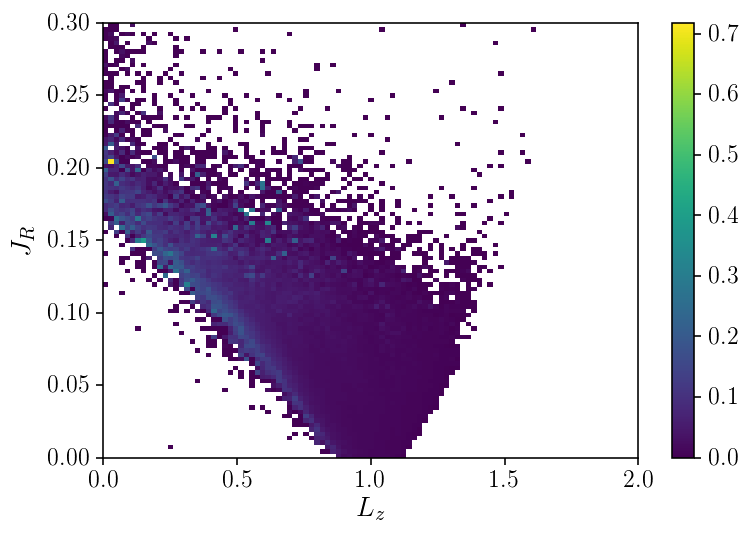

In [63]:

maxes = binned_statistic_2d(orbitcat['Lz'][mask], np.sqrt(orbitcat['jr'][mask]),orbitcat['omega_R'][mask], np.std, bins=[lzbins,jrbins])
plt.imshow(np.rot90(maxes[0]), extent=[0.,2.,0.,0.3], aspect='auto')

plt.colorbar()
plt.ylabel(r'$J_R$')
plt.xlabel(r'$L_z$')



In [ ]:
mport numpy as np
from scipy.stats import binned_statistic_dd

# N-dimensional M points.
N_dim, M = 3, 1000
points = np.random.uniform(0., 1., size=(M, N_dim))

# Weight for each point
weights = np.random.uniform(0., 1., M)

weights_histo, bin_edges, bin_indices = binned_statistic_dd(points,
                                                            weights,
                                                            statistic=np.max,
                                                            bins=5)

print weights_histo.shape # (5,5,5)